# BC2 - Predicting Cancellations


#### Andreia Bastos - 20210604
#### João Silva - 20211014
#### Pauline Richard - 20211019
#### Tiago Quaresma - 20210766

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [113]:
#useful libraries
import pandas as pd
import numpy as np
import scipy.stats 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import imblearn

from math import ceil
from  scipy.stats import chi2_contingency
from matplotlib import pyplot
from pprint import pprint

import xgboost 
import catboost

#outlier removal
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import DBSCAN

#feature selection
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV

#Model Selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#model evaluation
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification

#balancing strategies
from imblearn.over_sampling import SMOTE



In [6]:
def box_plots(df, features): 
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each box plot:
    for ax, feat in zip(axes.flatten(), features):
        sns.boxplot(x=df[feat], ax=ax)
    
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"
    plt.suptitle(title)
    plt.subplots_adjust(wspace=0.3)

    plt.show()

In [7]:
data = pd.read_csv('H2.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [9]:
data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,NaN,NaN,NaN,0.41727,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,NaN,NaN,NaN,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,NaN,NaN,NaN,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateMonth,79330,12,August,8983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrivalDateWeekNumber,79330.0,NaN,NaN,NaN,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,NaN,NaN,NaN,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,NaN,NaN,NaN,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,NaN,NaN,NaN,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,NaN,NaN,NaN,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,NaN,NaN,NaN,0.09137,0.372177,0.0,0.0,0.0,0.0,3.0


In [10]:
#checking for duplicates
#Show the duplicate records
data.loc[data.duplicated(keep='first'), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
18,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
22,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79289,0,186,2017,August,35,31,0,3,2,0.0,...,No Deposit,9,NULL,0,Transient,126.00,0,2,Check-Out,2017-09-03
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03


In [11]:
data.drop_duplicates(keep='last', inplace=True)

### Coherence Check

- Drop the bookings where there are no adults (390 observations)


In [12]:
data = data[~(data['Adults']==0)]

- Check if the cancelations in our target variable match with the values from the variable "ReservationStatus"

In [13]:
data['IsCanceled'].value_counts()

0    37101
1    15954
Name: IsCanceled, dtype: int64

In [14]:
data['ReservationStatus'].value_counts()

Check-Out    37101
Canceled     15210
No-Show        744
Name: ReservationStatus, dtype: int64

### Null Values

In [15]:
data.isnull().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       4
Babies                         0
Meal                           0
Country                        3
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
Company                        0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
Reservatio

- Children: 4
- Country: 3

- We assumed that the null values in the variable 'Children' corresponded to zero children, hence they were filled with '0'.

In [16]:
data['Children'].fillna(0, inplace=True)

- Since we only have 2 missing values in the 'Country' variable, we ended up deleting those rows.

In [17]:
data.dropna(axis=0, subset=['Country'], inplace = True)

### Data Exploration

In [18]:
data.dtypes

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                       float64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

In [19]:
metric_features = ['LeadTime','ArrivalDateWeekNumber', 'ArrivalDateYear', 'ArrivalDateDayOfMonth',
                       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
                       'Babies', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 
                       'BookingChanges', 'DaysInWaitingList', 'ADR',
                       'TotalOfSpecialRequests', 'RequiredCarParkingSpaces' ]


non_metric_features = data.columns.drop(metric_features).to_list()


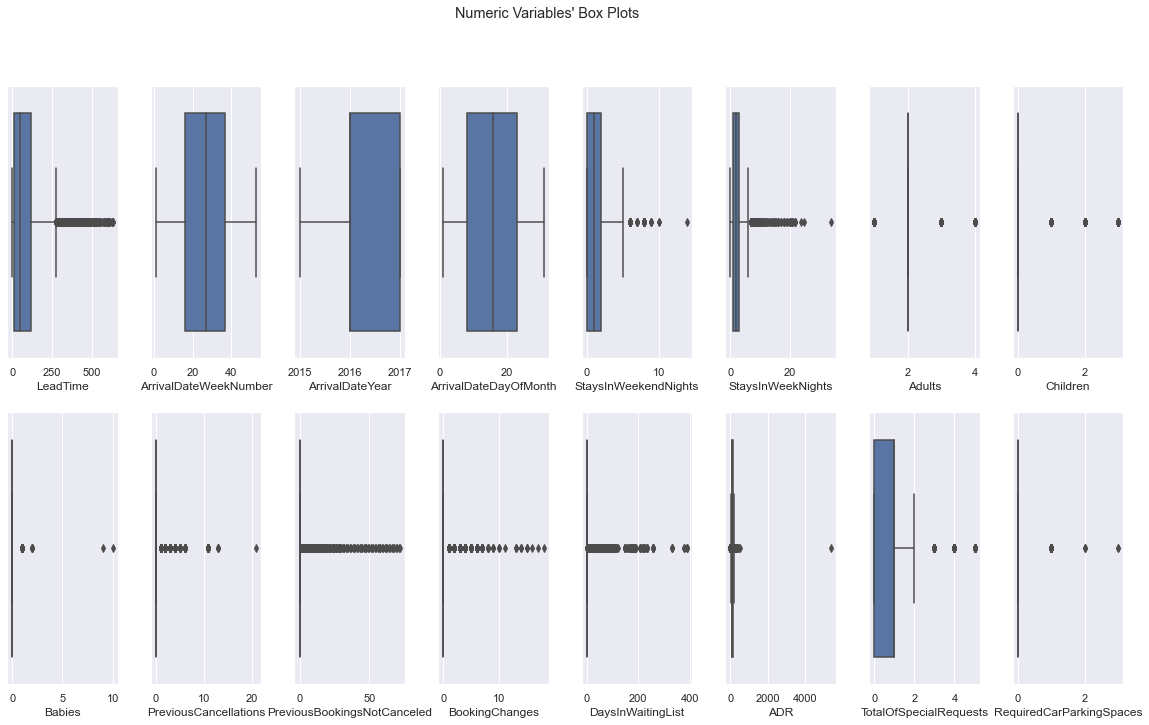

In [20]:
box_plots(data, metric_features)

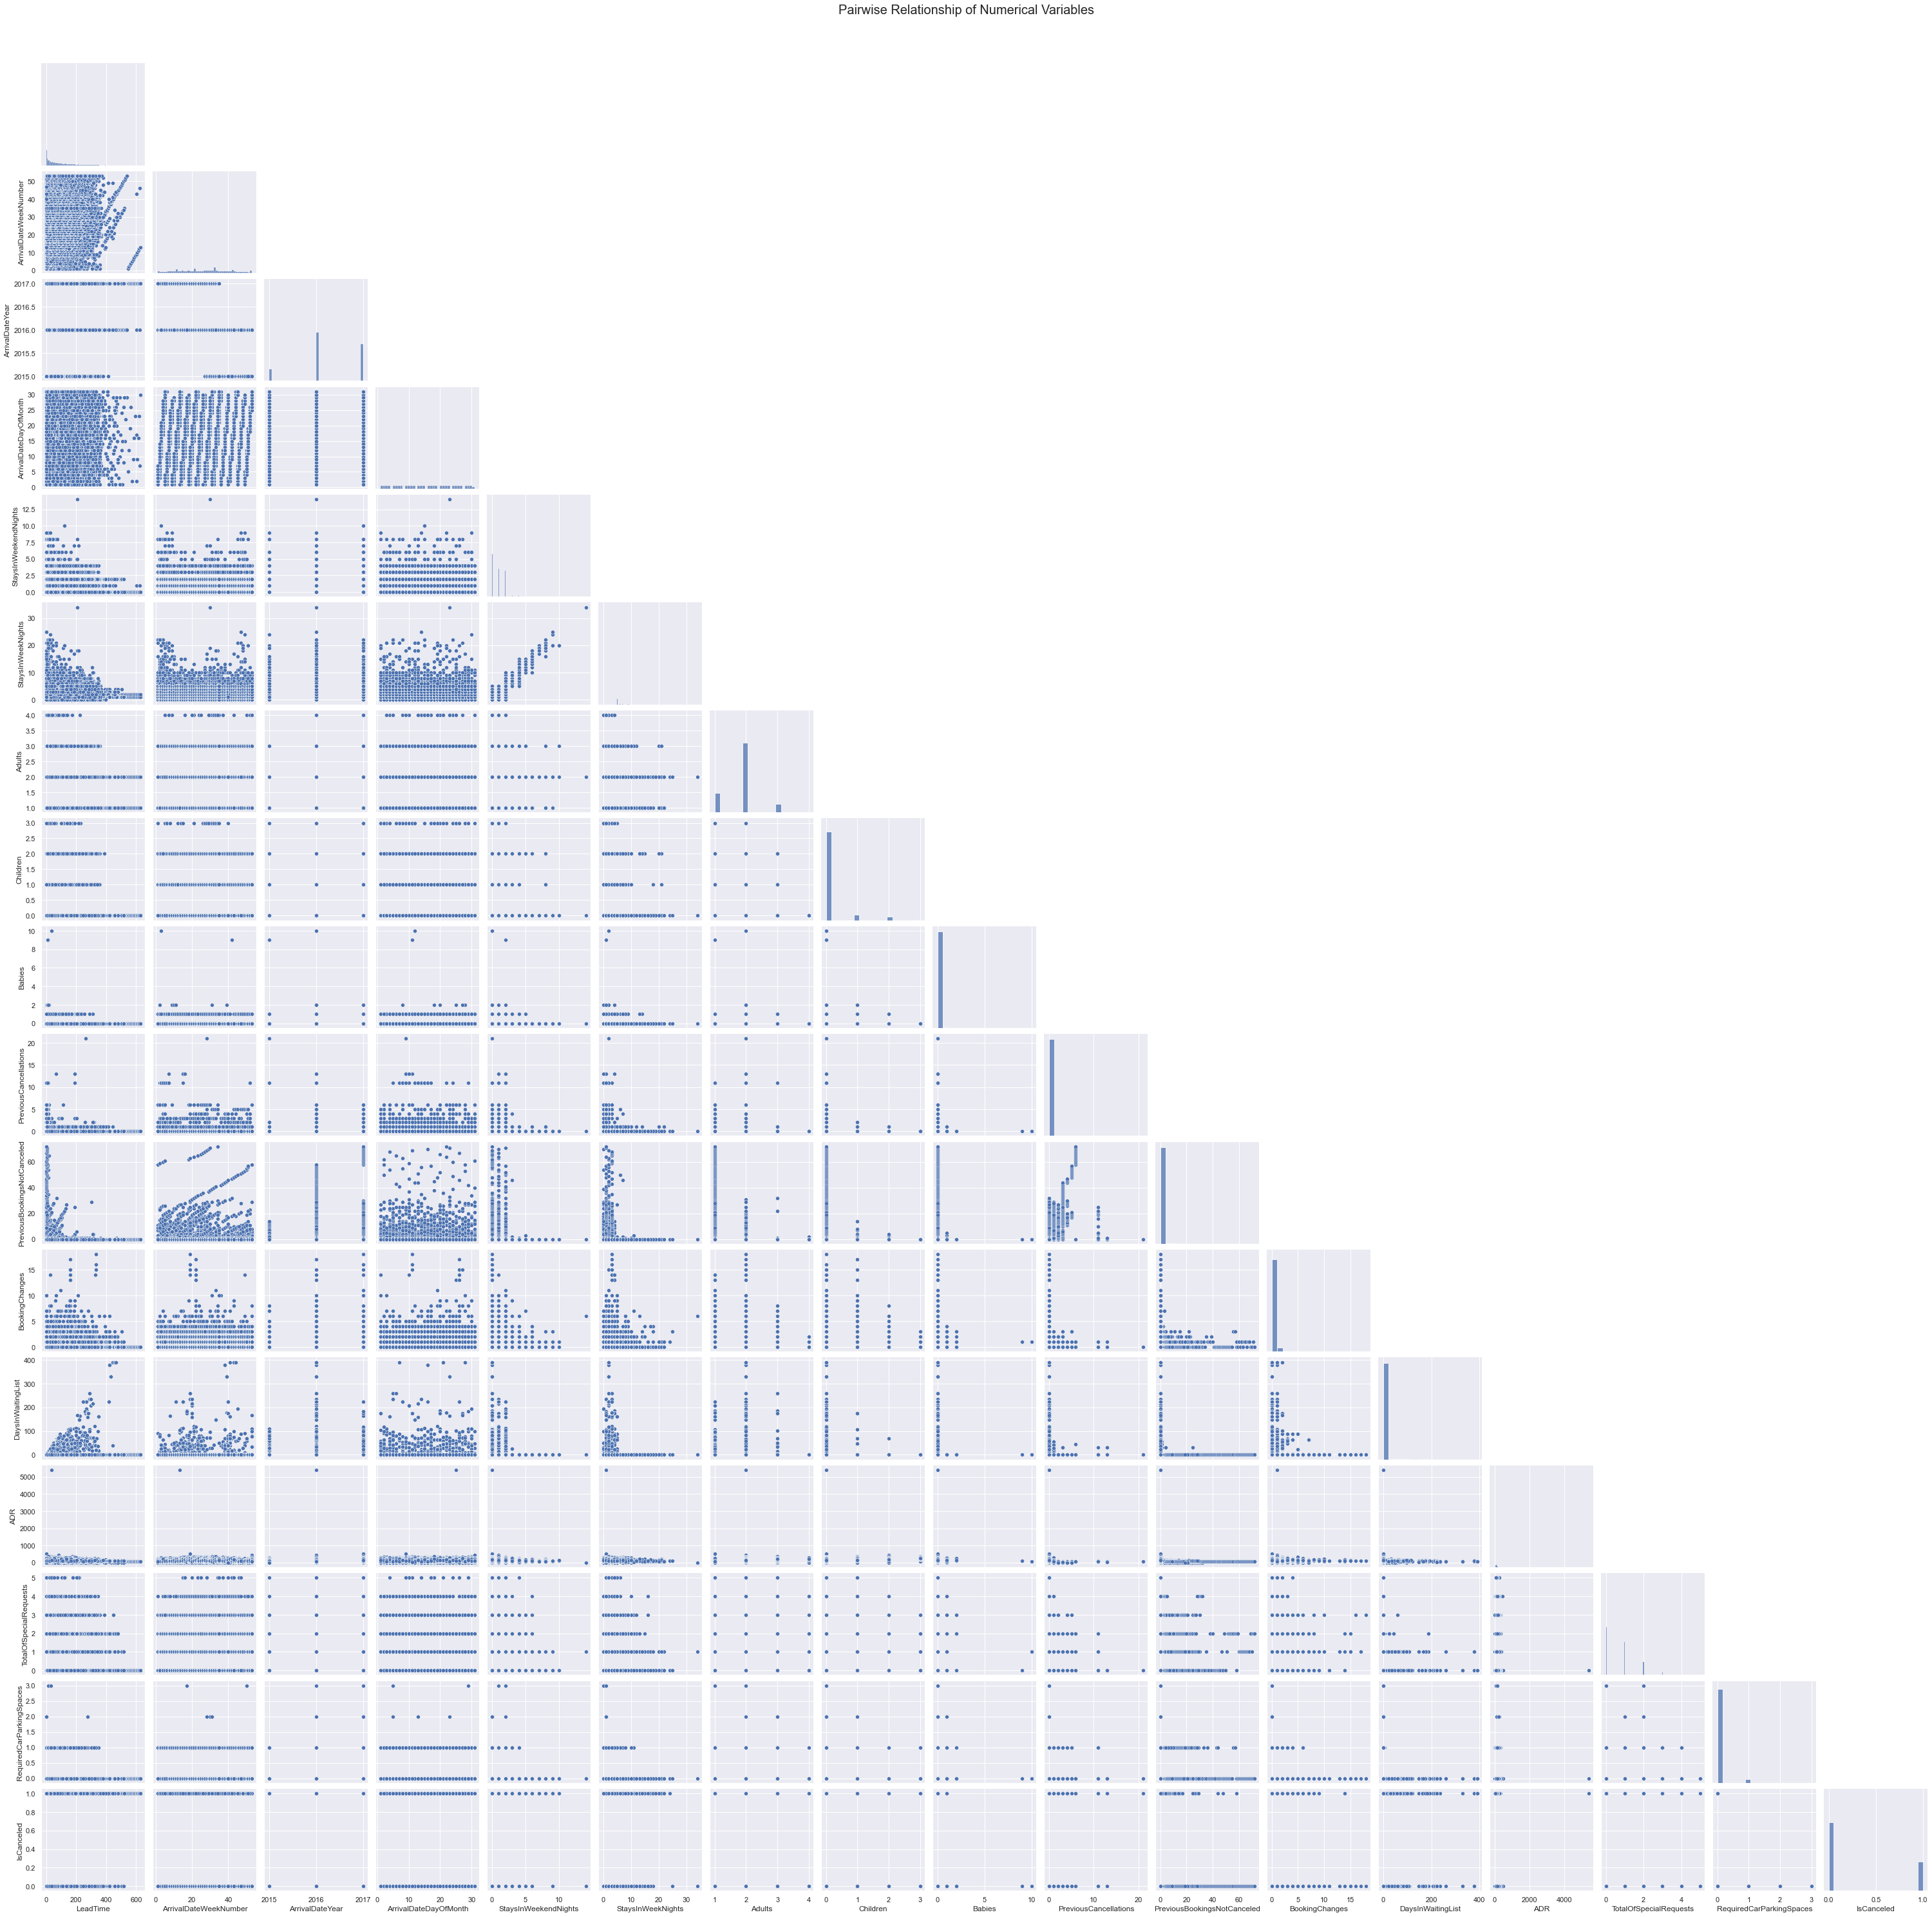

In [21]:
# Pairwise Relationship of Numerical Variables
sns.set()

features = metric_features + ['IsCanceled']

# Setting pairplot
sns.pairplot(data[features], diag_kind="hist", corner = True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
plt.show()

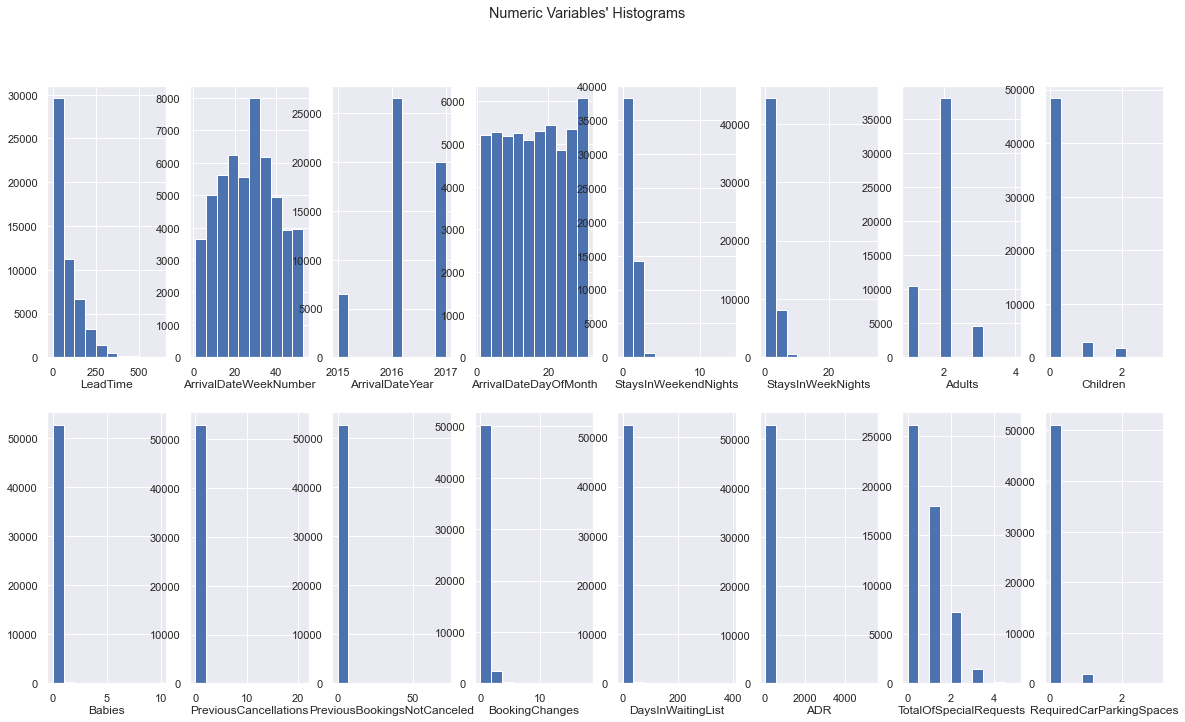

In [22]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(data[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

- Analysis by year and month:

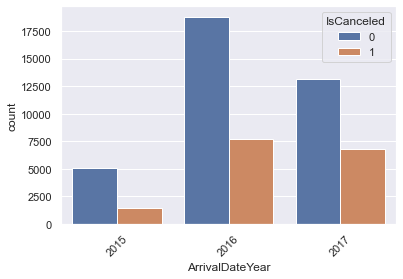

In [23]:
ax = sns.countplot(data = data, x='ArrivalDateYear', hue='IsCanceled')
ax.tick_params(axis='x', labelrotation=45)

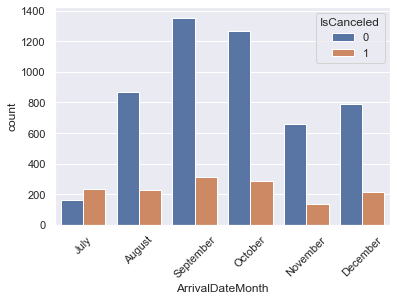

In [24]:
# 2015
data2015 = data[data['ArrivalDateYear'] == 2015]
ax = sns.countplot(data = data2015, x='ArrivalDateMonth', hue='IsCanceled')
ax.tick_params(axis='x', labelrotation=45)

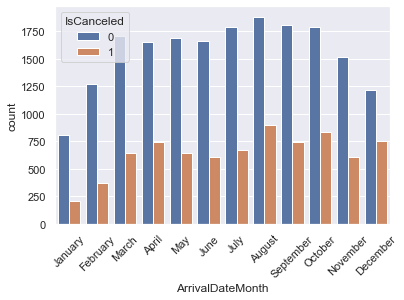

In [25]:
# 2016
data2016 = data[data['ArrivalDateYear'] == 2016]
ax = sns.countplot(data = data2016, x='ArrivalDateMonth', hue='IsCanceled')
ax.tick_params(axis='x', labelrotation=45)

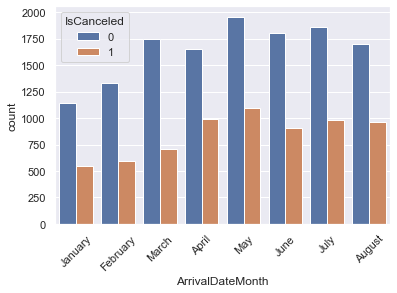

In [26]:
# 2017
data2017 = data[data['ArrivalDateYear'] == 2017]
ax = sns.countplot(data = data2017, x='ArrivalDateMonth', hue='IsCanceled')
ax.tick_params(axis='x', labelrotation=45)

In [27]:
print('Percentage of cancellations: ' + str(round(len(data[data['IsCanceled'] == 1])/len(data) * 100,2))+'%')

Percentage of cancellations: 30.07%


- Analyzing new guests VS old guests:

Cancelations among new guest:  0.306735932757413
Cancelations among old guests:  0.11352657004830918


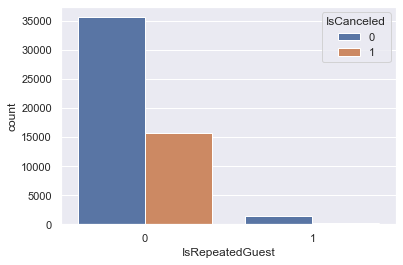

In [28]:
sns.countplot(data = data, x='IsRepeatedGuest', hue='IsCanceled')
new_guest = data[(data['IsRepeatedGuest']==0) & (data['IsCanceled']==1)]
old_guest = data[(data['IsRepeatedGuest']==1) & (data['IsCanceled']==1)]
print('Cancelations among new guest: ', (len(new_guest))/(len(data[data['IsRepeatedGuest']==0])))
print('Cancelations among old guests: ', (len(old_guest))/(len(data[data['IsRepeatedGuest']==1])))

In [29]:
# Old guests are less likely to cancel the reservation, when compared to new ones 

<AxesSubplot:xlabel='PreviousCancellations', ylabel='count'>

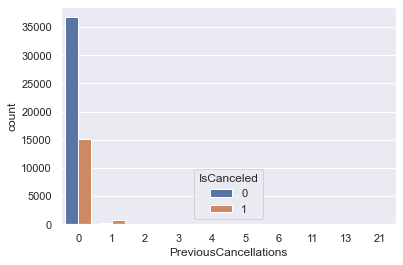

In [30]:
sns.countplot(data=data, x='PreviousCancellations', hue='IsCanceled')

In [31]:
# Customers who have cancelled their reservation once, are more likely to cancel again.

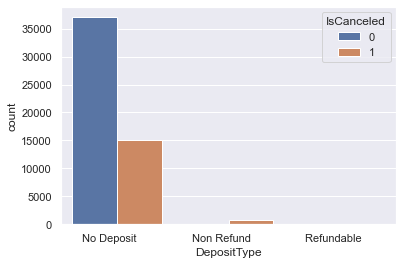

In [32]:
sns.countplot(data=data,x="DepositType", hue="IsCanceled");

- Analysing the Customer Type and the Distribution Channel with reference to the Cancelations

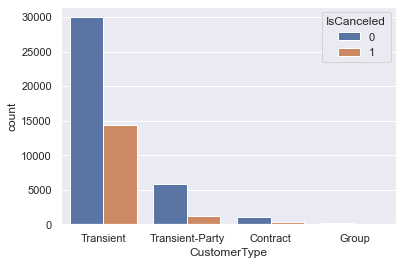

In [33]:
sns.countplot(data=data,x="CustomerType", hue="IsCanceled");

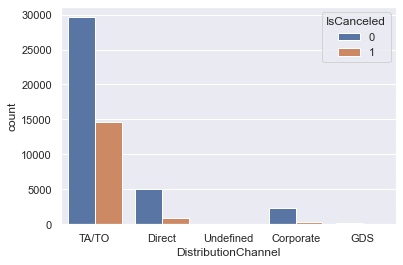

In [34]:
sns.countplot(data=data,x="DistributionChannel", hue="IsCanceled");

- Analysing the type of costumers per Distribution Channel

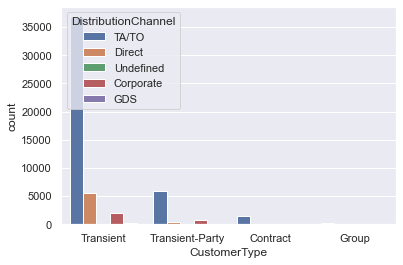

In [35]:
sns.countplot(data=data,x="CustomerType", hue="DistributionChannel");

- Analysing the most common meals with regard to the cancelations

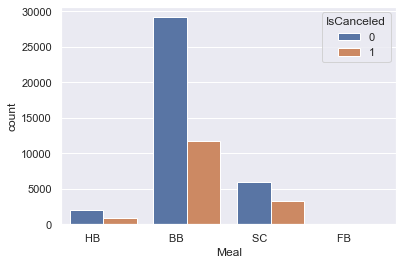

In [36]:
sns.countplot(data=data,x="Meal", hue="IsCanceled");

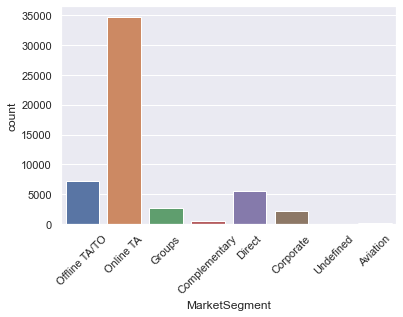

In [37]:
ax = sns.countplot(data=data,x="MarketSegment")
ax.tick_params(axis='x', labelrotation=45)

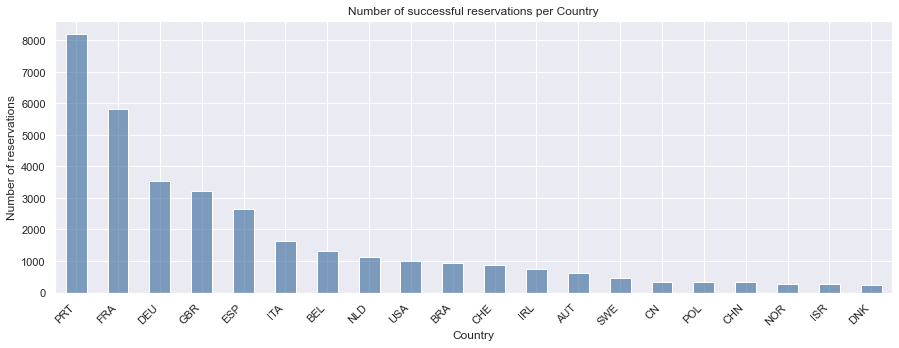

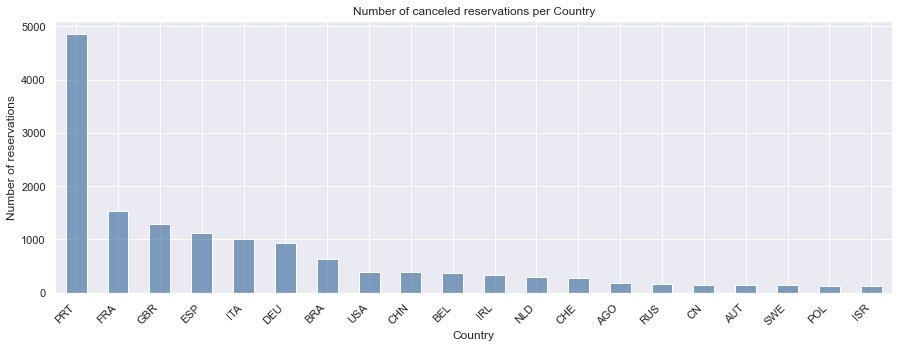

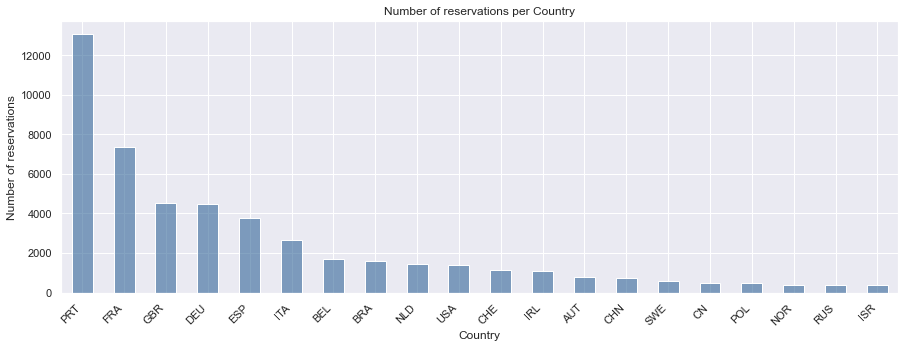

In [38]:
countries0 = data[data.IsCanceled == 0].groupby('Country').Country.count().sort_values(ascending = False)
countries1 = data[data.IsCanceled == 1].groupby('Country').Country.count().sort_values(ascending = False)
countries = data.groupby('Country').Country.count().sort_values(ascending = False)

plt.figure(figsize = (15, 5))
ax = countries0.head(20).plot(kind = 'bar', color=(0.2, 0.4, 0.6, 0.6))
ax.set_title('Number of successful reservations per Country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of reservations')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

plt.figure(figsize = (15, 5))
ax = countries1.head(20).plot(kind = 'bar', color=(0.2, 0.4, 0.6, 0.6))
ax.set_title('Number of canceled reservations per Country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of reservations')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
    
plt.figure(figsize = (15, 5))
ax = countries.head(20).plot(kind = 'bar', color=(0.2, 0.4, 0.6, 0.6))
ax.set_title('Number of reservations per Country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of reservations')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

In [39]:
#ax = sns.countplot(data=data,x="Continent")
#ax.tick_params(axis='x', labelrotation=45)

In [40]:
len(data[data['Country'] == 'PRT'][data['IsCanceled'] == 1])/len(data)*100

9.168363115433914

## Feature Engineering: 

#### MarketType

In [41]:
#data['MarketSegment']=data.MarketSegment.apply(lambda x: 'Agencies' if ((x == 'Offline TA/TO') | (x == 'Online TA')) else ('Companies' if ((x == 'Corporate') | (x == 'Aviation')) else 'Individual'))

#### Continent

In [42]:
#data['Continent'] = data.Country.apply(lambda x: 'Asia' if ((x == 'ARE') | (x == 'ARM') |(x == 'AZE') |(x == 'BGD') |(x == 'BHR') |(x == 'CHN') |(x == 'CN') |(x == 'CYP') |(x == 'GEO') |(x == 'HKG') |(x == 'IDN') |(x == 'IND') |(x == 'IRN') |(x == 'IRQ') |(x == 'ISR') |(x == 'JOR') |(x == 'JPN') |(x == 'KAZ') |(x == 'KHM') |(x == 'KOR') |(x == 'KWT') |(x == 'LAO') |(x == 'LBN') |(x == 'LKA') |(x == 'MAC') |(x == 'MDV') |(x == 'MMR') |(x == 'MYS') |(x == 'OMN') |(x == 'PAK') |(x == 'PHL') |(x == 'QAT') |(x == 'SAU') |(x == 'SGP') |(x == 'SYR') |(x == 'THA') |(x == 'TJK') |(x == 'TMP') |(x == 'TUR') |(x == 'TWN') |(x == 'UZB') |(x == 'VNM')) else  ('Africa' if ((x == 'AGO') | (x == 'ATF') |(x == 'BEN') |(x == 'BFA') |(x == 'CAF') |(x == 'CIV') |(x == 'CMR') |(x == 'COM') |(x == 'CPV') |(x == 'DZA') |(x == 'EGY') |(x == 'ETH') |(x == 'GAB') |(x == 'GHA') |(x == 'GNB') |(x == 'KEN') |(x == 'LBY') |(x == 'MLI') |(x == 'MOZ') |(x == 'MRT') |(x == 'MUS') |(x == 'MYT') |(x == 'NAM') |(x == 'NGA') |(x == 'RWA') |(x == 'SDN') |(x == 'SEN') |(x == 'SLE') |(x == 'STP') |(x == 'SYC') |(x == 'TGO') |(x == 'TUN') |(x == 'TZA') |(x == 'UGA') |(x == 'ZAF') |(x == 'ZMB') |(x == 'ZWE'))  else ('Antartica' if ((x == 'ATA')) else ('South America' if ((x == 'ARG') | (x == 'BOL') |(x == 'BRA') |(x == 'CHL') |(x == 'COL') |(x == 'ECU') |(x == 'GUY') |(x == 'PER') |(x == 'PRY') |(x == 'SUR') |(x == 'URY') |(x == 'VEN')) else ('North America' if ((x == 'ABW') | (x == 'AIA') |(x == 'BRB') |(x == 'CRI') |(x == 'CUB') |(x == 'DMA') |(x == 'DOM') |(x == 'GLP') |(x == 'GTM') |(x == 'JAM') |(x == 'KNA') |(x == 'LCA') |(x == 'MAR') |(x == 'MEX') |(x == 'NIC') |(x == 'PAN') |(x == 'PRI') |(x == 'SLV') |(x == 'USA') |(x == 'VGB')) else ('Europe' if ((x == 'ALB') | (x == 'AND') |(x == 'AUT') |(x == 'BEL') |(x == 'BGR') |(x == 'BIH') |(x == 'BLR') |(x == 'CHE') |(x == 'CZE') |(x == 'DEU') |(x == 'DNK') |(x == 'ESP') |(x == 'EST') |(x == 'FIN') |(x == 'FRA') |(x == 'FRO') |(x == 'GBR') |(x == 'GUY') |(x == 'GIB') |(x == 'GRC') |(x == 'HRV') |(x == 'HUN') |(x == 'IMN') |(x == 'IRL') |(x == 'ISL') |(x == 'ITA') |(x == 'JEY') |(x == 'LIE') |(x == 'LTU') |(x == 'LUX') |(x == 'LVA') |(x == 'MCO') |(x == 'MKD') |(x == 'MLT') |(x == 'MNE') |(x == 'NLD') |(x == 'NOR') |(x == 'POL') |(x == 'PRT') |(x == 'ROU') |(x == 'RUS') |(x == 'SRB') |(x == 'SVK') |(x == 'SVN') |(x == 'SWE') |(x == 'UKR')) else 'Oceania'))))))

#### ArrivalDateMonth

In [43]:
 dict = {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }

In [44]:
#Turn ArrivalDateMonth into Numerical
data = data.replace({"ArrivalDateMonth": dict})

#### ReservationStatusDate

In [45]:
#Putting in the right datetime format
data['ReservationStatusDate'] = pd.to_datetime(data['ReservationStatusDate'], format = '%Y-%m-%d')

In [46]:
#Change Categorical to Numerical Variable
data['ReservationStatusYear']=data.ReservationStatusDate.dt.year
data['ReservationStatusMonth']=data.ReservationStatusDate.dt.month
data['ReservationStatusDay']=data.ReservationStatusDate.dt.day
data=data.drop(['ReservationStatusDate'], axis=1)


#### Total Number of Nights

In [47]:
#Create the new variable
data['TotalNights'] = data['StaysInWeekendNights'] + data['StaysInWeekNights']

In [48]:
#Delete the Original variables
data=data.drop(['StaysInWeekendNights', 'StaysInWeekNights'], axis=1)

#### Total Under 18 (Children and Babies)

In [49]:
#Create the new variable
data['TotalUnder18'] = data['Children'] + data['Babies']

In [50]:
#Delete the Original variables
data=data.drop(['Children', 'Babies'], axis=1)

#### Redefining metric and non_metric features

In [51]:
metric_features = ['LeadTime','ArrivalDateWeekNumber', 'ArrivalDateMonth', 'ArrivalDateYear', 'ArrivalDateDayOfMonth',
                       'TotalNights', 'Adults', 'TotalUnder18', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 
                       'BookingChanges', 'DaysInWaitingList', 'ADR',
                       'TotalOfSpecialRequests', 'RequiredCarParkingSpaces','ReservationStatusYear', 'ReservationStatusMonth', 
                  'ReservationStatusDay']

non_metric_features = data.columns.drop(metric_features).to_list()

#### Re-check boxplots for outlier features


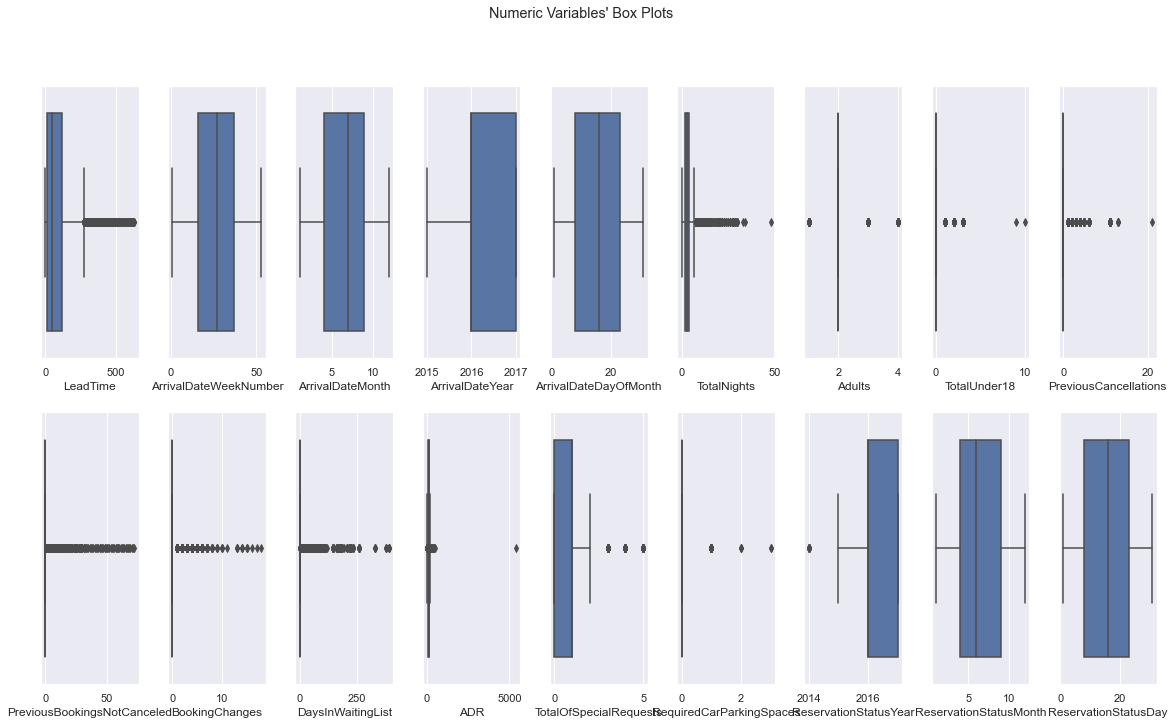

In [52]:
box_plots(data, metric_features)

## Outlier Removal: 

#### DBSCAN for outliers

In [53]:
# fazer funcao para todos os scalers e para o dbscan

In [56]:
data[metric_features].shape

(53052, 18)

In [60]:
# standardize data for DBSCAN method 
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(data[metric_features])
data_scaled = pd.DataFrame(scaled_feat, 
                           columns=data[metric_features].columns)
data_scaled

,LeadTime,ArrivalDateWeekNumber,ArrivalDateMonth,ArrivalDateYear,ArrivalDateDayOfMonth,TotalNights,Adults,TotalUnder18,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,TotalOfSpecialRequests,RequiredCarParkingSpaces,ReservationStatusYear,ReservationStatusMonth,ReservationStatusDay
0,-0.873231,0.027189,0.185462,-1.901776,-1.675888,-0.558242,-1.701229,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-2.330378,-0.852446,-0.191524,-1.878752,0.242214,-1.451807
1,0.126744,0.027189,0.185462,-1.901776,-1.675888,0.421021,0.211248,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-0.730059,0.347829,-0.191524,-1.878752,0.242214,-1.680318
2,-0.153737,0.027189,0.185462,-1.901776,-1.675888,0.421021,-1.701229,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-0.907873,0.347829,-0.191524,-1.878752,-0.691941,1.633088
3,0.175523,0.027189,0.185462,-1.901776,-1.675888,1.400285,0.211248,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-0.730059,1.548105,-0.191524,-1.878752,-0.069171,0.833301
4,0.273082,0.027189,0.185462,-1.901776,-1.562284,-0.558242,0.211248,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-0.730059,0.347829,-0.191524,-1.878752,-0.691941,-1.566062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53047,-0.665919,0.616595,0.510992,1.130412,1.618624,1.889917,0.211248,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-0.319206,-0.852446,-0.191524,1.181474,0.864983,-1.109041
53048,0.297471,0.616595,0.510992,1.130412,1.732227,1.889917,2.123725,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,2.385437,1.548105,-0.191524,1.181474,0.864983,-0.994786
53049,-0.531776,0.616595,0.510992,1.130412,1.732227,1.889917,0.211248,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,0.968789,3.948656,-0.191524,1.181474,0.864983,-0.994786
53050,0.382835,0.616595,0.510992,1.130412,1.732227,1.889917,0.211248,-0.299295,-0.095962,-0.094052,-0.356509,-0.085838,-0.146414,-0.852446,-0.191524,1.181474,0.864983,-0.994786


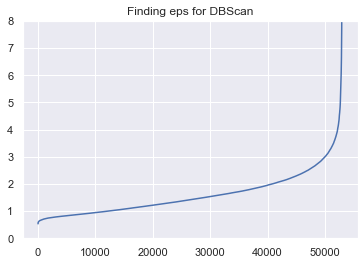

In [61]:
neigh = NearestNeighbors(n_neighbors=36)
neigh.fit(data_scaled)
distances, _ = neigh.kneighbors(data_scaled)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylim(0,8)
plt.title('Finding eps for DBScan')
plt.show()

In [62]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=4, min_samples=32, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(data_scaled)
data['label']=dbscan_labels

In [63]:
#check the % of outliers
round(len(data[data['label']==-1])/len(data),7)

0.0058056

In [64]:
outliers = data[data['label'] == -1]
data = data[data['label'] != -1]
data.drop('label', axis = 1, inplace = True)

### Splitting and encoding data for Feature Selection: 

In [68]:
data_encoded = data.copy()
data_encoded[non_metric_features] = data_encoded[non_metric_features].apply(LabelEncoder().fit_transform)

In [69]:
# Input Variables and Target Split: 
target = data['IsCanceled']
data_train = data_encoded.drop(['IsCanceled'], axis=1) 

In [70]:
X_train, X_val, y_train, y_val = train_test_split(data_train,target, test_size = 0.2, random_state = 15, stratify = target, shuffle = True)

## Standardizing data for some feature selection techniques

In [71]:
scaler= StandardScaler().fit(X_train[metric_features])
trainscaled = scaler.transform(X_train[metric_features])
X_train_scaled = X_train.copy()
X_train_scaled[metric_features] = trainscaled

scaler_val= StandardScaler().fit(X_val[metric_features])
valscaled = scaler_val.transform(X_val[metric_features])
X_val_scaled = X_val.copy()
X_val_scaled[metric_features] = valscaled


## Feature selection

### Categorical Variables

#### 1.1) Chi-Square for categorical data

In [72]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [73]:
train_cat = data_encoded[non_metric_features].drop(columns = 'IsCanceled')
for var in train_cat:
    TestIndependence(train_cat[var],data['IsCanceled'],var)

Meal is IMPORTANT for Prediction
Country is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
IsRepeatedGuest is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
Agent is IMPORTANT for Prediction
Company is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
ReservationStatus is IMPORTANT for Prediction


#### 1.2) Visualization

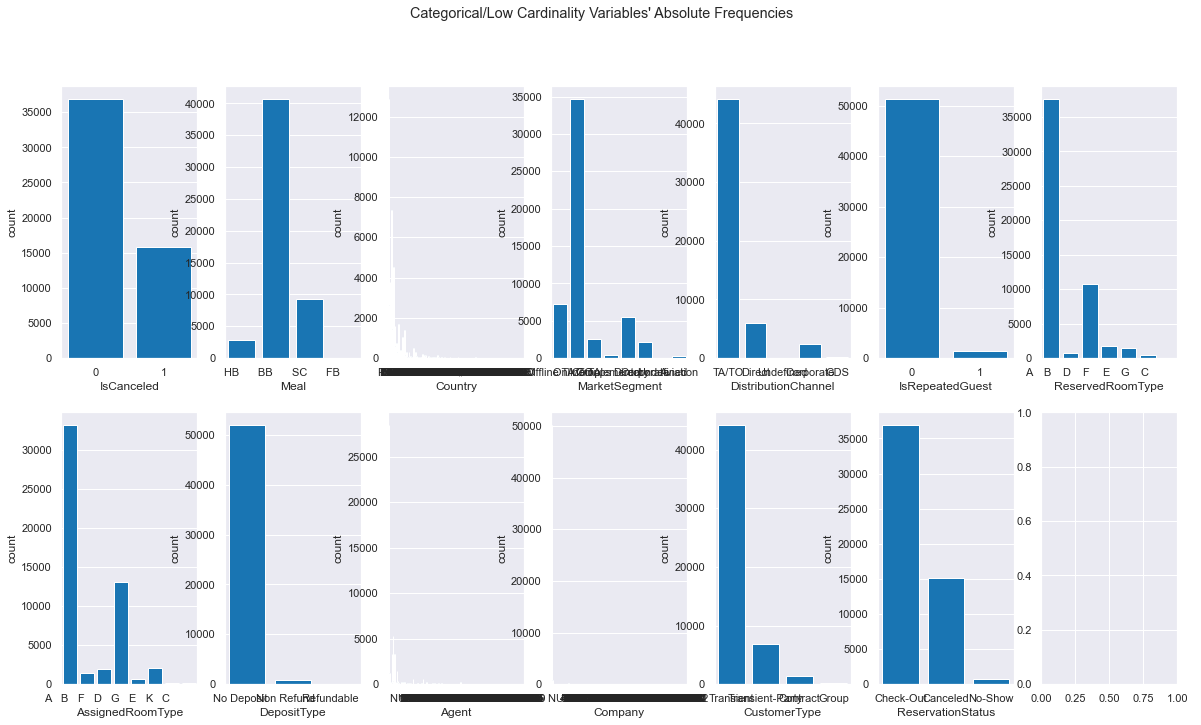

In [74]:
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(data[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)
plt.show()

Text(0, 0.5, 'Proportion of IsCanceled')

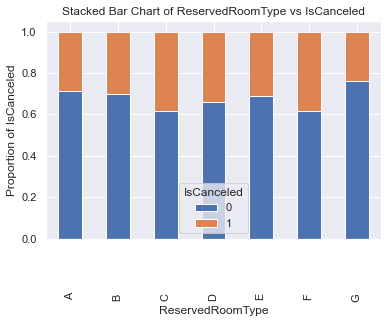

In [75]:
table=pd.crosstab(data.ReservedRoomType,data.IsCanceled)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of ReservedRoomType vs IsCanceled')
plt.xlabel('ReservedRoomType')
plt.ylabel('Proportion of IsCanceled')

Text(0, 0.5, 'Proportion of IsCanceled')

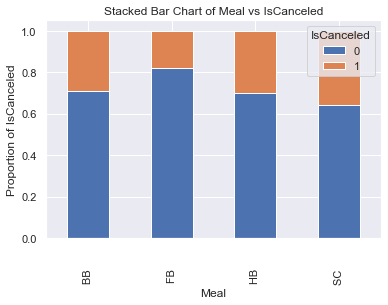

In [76]:
table=pd.crosstab(data.Meal,data.IsCanceled)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Meal vs IsCanceled')
plt.xlabel('Meal')
plt.ylabel('Proportion of IsCanceled')

In [77]:
data['Meal'].value_counts()

BB           40657
SC            9299
HB            2777
FB              11
Name: Meal, dtype: int64

**Conclusion**: After looking at all the categorical variables' relevancy
- Meal: does not have a rel impact except for FB
- Country, Company, Agent : impossible to visually tell
- all the rest do have an impact on the target

## Numerical variables

In [78]:
X_train_num=X_train_scaled[metric_features]
X_val_num=X_val_scaled[metric_features]

In [79]:
feature_list = list(X_train[metric_features].columns)

### 1) Filter methods

#### 1.1) Univariate variables

In [80]:
X_train[metric_features].var()

LeadTime                       6696.905833
ArrivalDateWeekNumber           184.027768
ArrivalDateMonth                  9.422412
ArrivalDateYear                   0.436846
ArrivalDateDayOfMonth            77.309784
TotalNights                       3.737830
Adults                            0.272476
TotalUnder18                      0.192261
PreviousCancellations             0.022340
PreviousBookingsNotCanceled       0.903564
BookingChanges                    0.387343
DaysInWaitingList               113.195780
ADR                            1746.854625
TotalOfSpecialRequests            0.689166
RequiredCarParkingSpaces          0.033736
ReservationStatusYear             0.428281
ReservationStatusMonth           10.301846
ReservationStatusDay             76.559028
dtype: float64

#### 1.2) Spearman and Phix Correlation

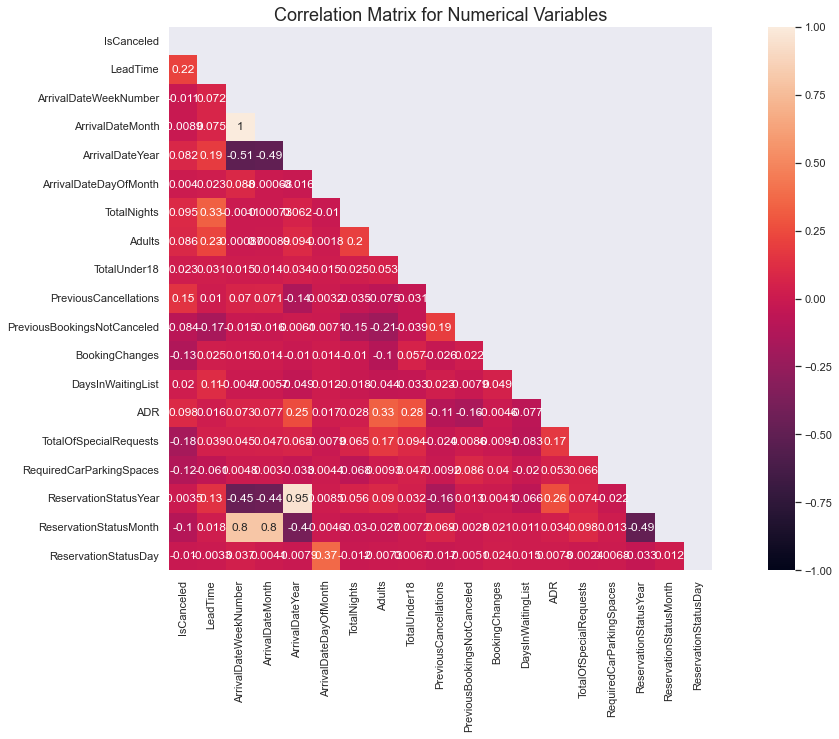

In [81]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

mask = np.zeros_like(data[['IsCanceled'] + metric_features].corr(method="spearman"), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(data[['IsCanceled'] + metric_features].corr(method="spearman"),vmin=-1, vmax=1, square=True, annot=True, mask=mask)

plt.title('Correlation Matrix for Numerical Variables', fontsize=18)
plt.show()

interval columns not set, guessing: ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'Adults', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'ReservationStatusYear', 'ReservationStatusMonth', 'ReservationStatusDay', 'TotalNights', 'TotalUnder18']


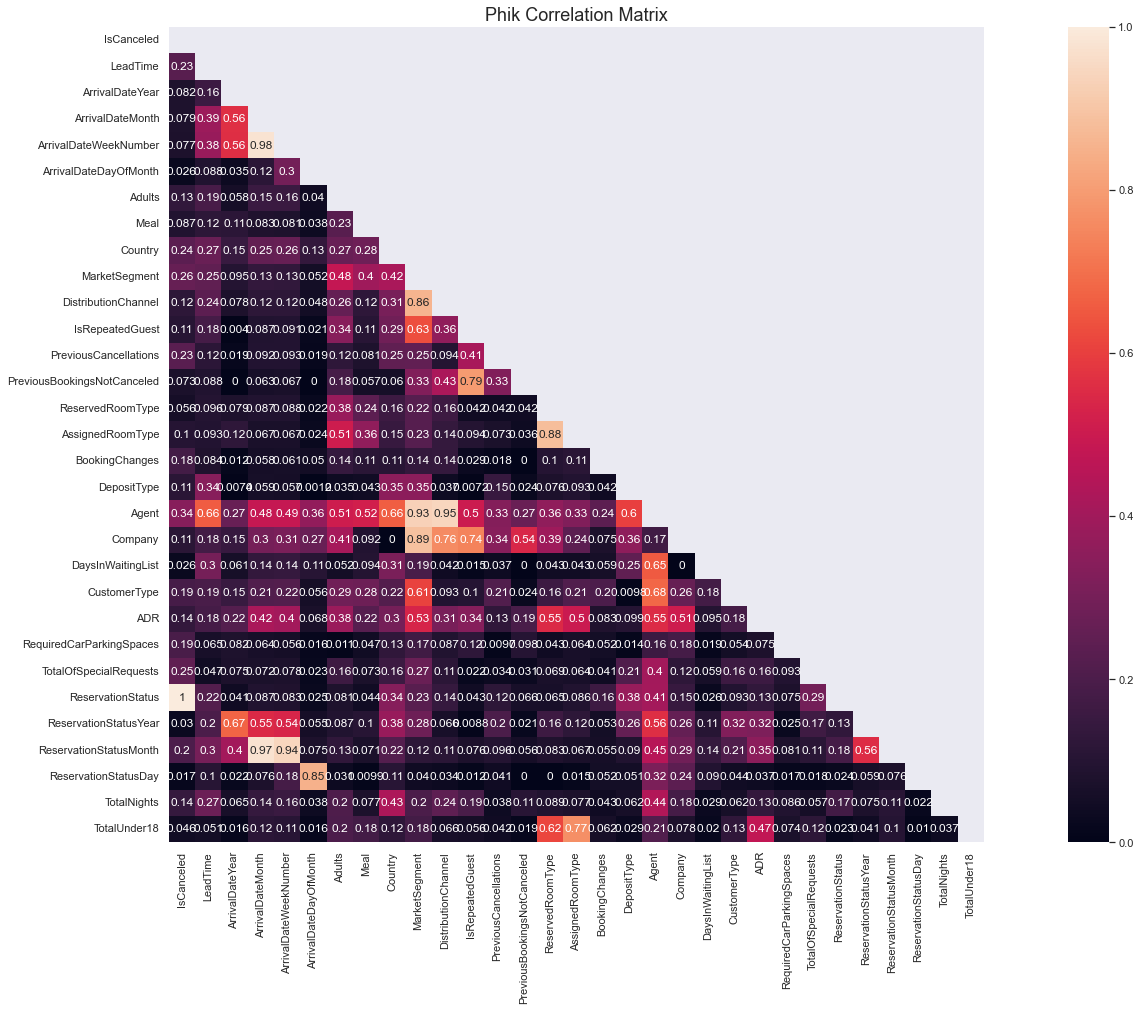

In [82]:
### ! pip install phik
import phik
phik_matrix = data.phik_matrix()
fig, axes = plt.subplots(1, 1, figsize=(30, 15))

mask = np.zeros_like(phik_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(phik_matrix,vmin=0, vmax=1, square=True, annot=True, mask=mask)

plt.title('Phik Correlation Matrix', fontsize=18)
plt.show()

**Conclusion:** we should remove
- 'ReservationStatusYear' or 'ArrivalDateYear'
- 'ArrivalDateMonth' or 'ArrivalDateWeekNumber'

### 2) Wrapper Methods

#### 2.1) RFE: Recursive Feature Elimination 


In [83]:
classifier = RandomForestClassifier()

In [84]:
n_features_to_select = 1
rfe = RFE(classifier, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=1)

In [85]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)


1 ReservationStatus
2 Agent
3 TotalOfSpecialRequests
4 LeadTime
5 DepositType
6 Country
7 MarketSegment
8 ArrivalDateMonth
9 ReservationStatusMonth
10 ArrivalDateWeekNumber
11 PreviousCancellations
12 ADR
13 ReservationStatusDay
14 ArrivalDateDayOfMonth
15 TotalNights
16 BookingChanges
17 RequiredCarParkingSpaces
18 CustomerType
19 ReservationStatusYear
20 DistributionChannel
21 ArrivalDateYear
22 AssignedRoomType
23 Adults
24 ReservedRoomType
25 Meal
26 PreviousBookingsNotCanceled
27 Company
28 IsRepeatedGuest
29 TotalUnder18
30 DaysInWaitingList


### 3) Embedded Methods

#### 3.1) Lasso Regression

In [86]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [87]:
reg = LassoCV()
reg.fit(X_train_num, y_train)
coef = pd.Series(reg.coef_, index = X_train_num.columns)
coef

LeadTime                      -0.052532
ArrivalDateWeekNumber          0.304886
ArrivalDateMonth               0.244573
ArrivalDateYear                1.364900
ArrivalDateDayOfMonth          0.021935
TotalNights                    0.034054
Adults                         0.012867
TotalUnder18                   0.000453
PreviousCancellations          0.050038
PreviousBookingsNotCanceled   -0.022610
BookingChanges                -0.020037
DaysInWaitingList              0.004869
ADR                            0.032484
TotalOfSpecialRequests        -0.039026
RequiredCarParkingSpaces      -0.034744
ReservationStatusYear         -1.338661
ReservationStatusMonth        -0.581706
ReservationStatusDay          -0.052497
dtype: float64

In [88]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 0 variables


In [89]:
coef.sort_values()

ReservationStatusYear         -1.338661
ReservationStatusMonth        -0.581706
LeadTime                      -0.052532
ReservationStatusDay          -0.052497
TotalOfSpecialRequests        -0.039026
RequiredCarParkingSpaces      -0.034744
PreviousBookingsNotCanceled   -0.022610
BookingChanges                -0.020037
TotalUnder18                   0.000453
DaysInWaitingList              0.004869
Adults                         0.012867
ArrivalDateDayOfMonth          0.021935
ADR                            0.032484
TotalNights                    0.034054
PreviousCancellations          0.050038
ArrivalDateMonth               0.244573
ArrivalDateWeekNumber          0.304886
ArrivalDateYear                1.364900
dtype: float64

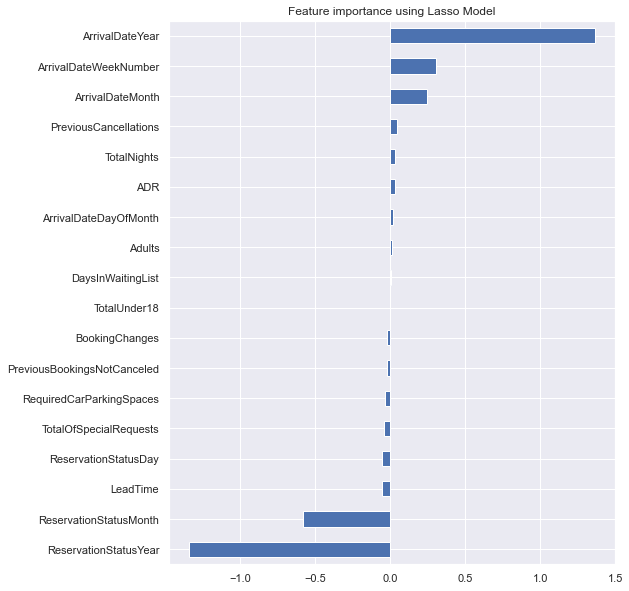

In [90]:
plot_importance(coef,'Lasso')

#### 3.2) Decision Tree Feature Importances:  

In [91]:
feature_list

['LeadTime',
 'ArrivalDateWeekNumber',
 'ArrivalDateMonth',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'TotalNights',
 'Adults',
 'TotalUnder18',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'TotalOfSpecialRequests',
 'RequiredCarParkingSpaces',
 'ReservationStatusYear',
 'ReservationStatusMonth',
 'ReservationStatusDay']

In [92]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train_num, y_train)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: ReservationStatusMonth Importance: 0.19
Variable: ArrivalDateWeekNumber Importance: 0.18
Variable: ReservationStatusDay Importance: 0.14
Variable: ArrivalDateMonth     Importance: 0.11
Variable: ArrivalDateDayOfMonth Importance: 0.1
Variable: LeadTime             Importance: 0.08
Variable: ADR                  Importance: 0.05
Variable: TotalOfSpecialRequests Importance: 0.04
Variable: ArrivalDateYear      Importance: 0.02
Variable: TotalNights          Importance: 0.02
Variable: PreviousCancellations Importance: 0.02
Variable: BookingChanges       Importance: 0.02
Variable: ReservationStatusYear Importance: 0.02
Variable: PreviousBookingsNotCanceled Importance: 0.01
Variable: Adults               Importance: 0.0
Variable: TotalUnder18         Importance: 0.0
Variable: DaysInWaitingList    Importance: 0.0
Variable: RequiredCarParkingSpaces Importance: 0.0


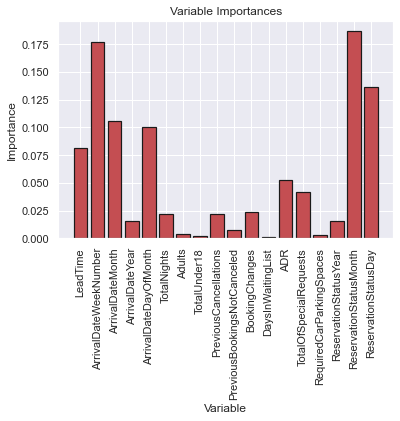

In [93]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Final Insights:



### Non-metric variables
**KEEP**
- MarketSegment 
- IsRepeatedGuest
- ReservedRoomType 
- DepositType 
- CustomerType 
- Agent
- Country


**DROP**
- Meal => only FB seems to matter and it represents only 44 bookings
- DistributionChannel => giving the same info than market segment
- Company => doesn't seem relevant for our objective
- ReservationStatus => same info than target: IsCanceled

### Metric variables
**KEEP**
- LeadTime
- ArrivalDateWeekNumber => (highly correlated with Month)
- TotalNights 
- TotalUnder18
- PreviousCancellations => important to predict Cancelation 
- PreviousBookingsNotCanceled => important to predict Cancelation 
- BookingChanges => important to predict Cancelation 
- TotalOfSpecialRequests => important to predict Cancelation
                                 
**DROP**
- ADR
- Adults
- DaysInWaitingList
- ArrivalDateMonth 
- ArrivalDateYear
- ArrivalDateDayOfMonth
- ReservationStatusYear, ReservationStatusMonth, ReservationStatusDay => only related to ReservationStatus

In [94]:
selected_features = ['LeadTime',
'ArrivalDateWeekNumber', 
'TotalNights',
'TotalUnder18',
'PreviousCancellations', 
'PreviousBookingsNotCanceled',
'BookingChanges',
'TotalOfSpecialRequests',
'MarketSegment',
'IsRepeatedGuest',
'ReservedRoomType',
'DepositType',
'CustomerType',
'Agent',
'Country']

selected_metric_features = ['LeadTime',
'ArrivalDateWeekNumber', 
'TotalNights',
'TotalUnder18',
'PreviousCancellations', 
'PreviousBookingsNotCanceled',
'BookingChanges',
'TotalOfSpecialRequests']


selected_non_metric_features = ['MarketSegment',
'IsRepeatedGuest',
'ReservedRoomType',
'DepositType',
'CustomerType',
'Agent',
'Country']

In [95]:
data['DepositType'].unique()

array(['No Deposit     ', 'Non Refund     ', 'Refundable     '],
      dtype=object)

In [96]:
data['MarketSegment'].value_counts()

Online TA        34661
Offline TA/TO     7222
Direct            5488
Groups            2594
Corporate         2086
Complementary      465
Aviation           226
Undefined            2
Name: MarketSegment, dtype: int64

## Model Selection :

In [97]:
# Creating the ArrivalDate feature to order the dataset 
data['ArrivalDate'] = data['ArrivalDateYear'].astype(str) + "-" + data['ArrivalDateMonth'].astype(str) + "-" + data['ArrivalDateDayOfMonth'].astype(str)
data['ArrivalDate'] = pd.to_datetime(data['ArrivalDate'], format="%Y-%m-%d")

#Ordering the records by the ArrivalDate
data = data.sort_values(['ArrivalDate'])
data.reset_index(drop=True,inplace=True) #dropping the previous index

In [105]:
not_selected = data.drop(columns = selected_features).columns.to_list()


X = pd.get_dummies(data.drop(columns=not_selected))
y = data['IsCanceled']


# Stratified K-Fold Cross Validation Method
kfold_cv=StratifiedKFold(n_splits=10,random_state = 26, shuffle =True)

for train_index, test_index in kfold_cv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [98]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [120]:
def metrics_smote(expected_y_train, y_pred_train , expected_y_test, y_pred_test,expected_y_train_smote,
           y_pred_train_smote,y_pred_test_smote):
    print('_________________________________________________________________________________________________________')
    print('                                                     TRAIN                                               ')
    print('---------------------------------------------------------------------------------------------------------')
    print(classification_report(expected_y_train, y_pred_train))
    print(confusion_matrix(expected_y_train, y_pred_train))


    print('_________________________________________________________________________________________________________')
    print('                                                VALIDATION                                               ')
    print('---------------------------------------------------------------------------------------------------------')
    print(classification_report(expected_y_test, y_pred_test))




    print('_________________________________________________________________________________________________________')
    print('                                                     TRAIN SMOTE                                         ')
    print('---------------------------------------------------------------------------------------------------------')
    print(classification_report(expected_y_train_smote, y_pred_train_smote))
    print(confusion_matrix(expected_y_train_smote, y_pred_train_smote))


    print('_________________________________________________________________________________________________________')
    print('                                                VALIDATION SMOTE                                            ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(expected_y_test, y_pred_test_smote))
    print(confusion_matrix(expected_y_test, y_pred_test_smote))
    
    cm = confusion_matrix(expected_y_test, y_pred_test)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

    # visualize confusion matrix with seaborn heatmap

    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Non-cancel:0', 'Predict Cancel:1'], 
                                     index=['Actual Non-cancel:0', 'Actual Cancel:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Reds')

### Random Forest

In [106]:
# rf_params = { 'n_estimators' : [200,300,500,800,1000],
#             'max_depth' : [10, 15, 20, 30, None],
#             'max_features': ['auto', 'sqrt'],
#             'min_samples_leaf' : [1,2,4],
#             'min_samples_split' : [2, 5, 10,15],
#             'bootstrap' : [True, False]}
# rf_clf = RandomForestClassifier(random_state = 26)
# rf_cv = HalvingGridSearchCV(estimator=rf_clf, 
#                           cv = kfold_cv, 
#                           param_grid=rf_params, 
#                           scoring='accuracy', 
#                           n_jobs=-1) 
# rf = rf_cv.fit(X_train,y_train)


# print('Best parameters set found:',rf.best_params_)
# print('Score with best parameters:',rf.best_score_)

_________________________________________________________________________________________________________
                                                     TRAIN                                               
---------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     33176
           1       0.88      0.83      0.86     14294

    accuracy                           0.92     47470
   macro avg       0.91      0.89      0.90     47470
weighted avg       0.92      0.92      0.92     47470

[[31618  1558]
 [ 2382 11912]]
_________________________________________________________________________________________________________
                                                VALIDATION                                               
---------------------------------------------------------------------------------------------------------
      

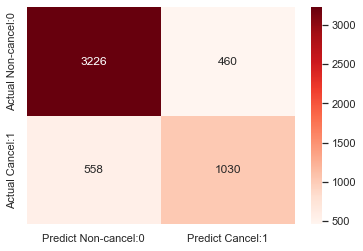

In [107]:
#Model 
rforest = rforest_smote = RandomForestClassifier(n_estimators = 300,max_features='sqrt'
                 , min_samples_split=10,random_state=26) 
#SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#Fit Model
rforest.fit(X_train, y_train)
rforest_smote.fit(X_train_res, y_train_res)

#Make predictions
y_pred_train = rforest.predict(X_train)
y_pred_train_smote = rforest_smote.predict(X_train_res)

y_pred_test = rforest.predict(X_test)
y_pred_test_smote= rforest_smote.predict(X_test)

expected_y_train = y_train
expected_y_train_smote = y_train_res

expected_y_test = y_test

metrics_smote(expected_y_train, y_pred_train , expected_y_test, y_pred_test,expected_y_train_smote
           ,y_pred_train_smote,y_pred_test_smote)

### XGBoost

In [108]:
# parameters = {
#     'learning_rate': [0.01] ,
#     'n_estimators': [800],
#     'max_depth' :[8],
#     'objective':['binary:logistic']
# }

# xgb_clf = XGBClassifier(random_state = 18)
# xgb_cv = HalvingGridSearchCV(estimator=xgb_clf, cv = 5, param_grid=parameters, scoring='f1', n_jobs=-1)
# xgb_cv.fit(X_train,y_train)

# y_xgb_train= xgb_cv.predict(X_train)
# y_xgb_val = xgb_cv.predict(X_test) 




[23:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
_________________________________________________________________________________________________________
                                                     TRAIN                                               
---------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       

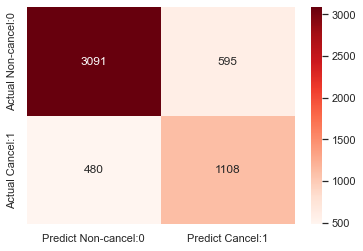

In [115]:
#Model 
xgboost = xgboost_smote = XGBClassifier(random_state = 26, learning_rate=0.01,
                                               n_estimators=800,max_depth = 8) 
#SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#Fit Model
xgboost.fit(X_train, y_train)
xgboost_smote.fit(X_train_res, y_train_res)

#Make predictions
y_pred_train = xgboost.predict(X_train)
y_pred_train_smote = xgboost_smote.predict(X_train_res)

y_pred_test = xgboost.predict(X_test)
y_pred_test_smote= xgboost_smote.predict(X_test)

expected_y_train = y_train
expected_y_train_smote = y_train_res

expected_y_test = y_test

metrics_smote(expected_y_train, y_pred_train , expected_y_test, y_pred_test,expected_y_train_smote,
           y_pred_train_smote,y_pred_test_smote)

### CATBoost

_________________________________________________________________________________________________________
                                                     TRAIN                                               
---------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     33176
           1       0.69      0.71      0.70     14294

    accuracy                           0.82     47470
   macro avg       0.78      0.78      0.78     47470
weighted avg       0.82      0.82      0.82     47470

[[28604  4572]
 [ 4194 10100]]
_________________________________________________________________________________________________________
                                                VALIDATION                                               
---------------------------------------------------------------------------------------------------------
      

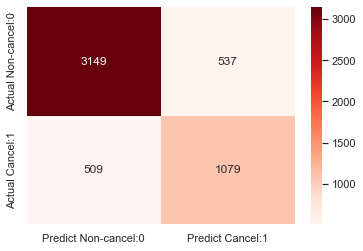

In [121]:
#Model 
catboost = catboost_smote = CatBoostClassifier(random_state = 26, depth=7, learning_rate=0.01,
                                               n_estimators=2000) 
#SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#Fit Model
catboost.fit(X_train, y_train,silent = True)
catboost_smote.fit(X_train_res, y_train_res,silent = True)

#Make predictions
y_pred_train = catboost.predict(X_train)
y_pred_train_smote = catboost_smote.predict(X_train_res)

y_pred_test = catboost.predict(X_test)
y_pred_test_smote= catboost_smote.predict(X_test)

expected_y_train = y_train
expected_y_train_smote = y_train_res

expected_y_test = y_test

metrics_smote(expected_y_train, y_pred_train , expected_y_test, y_pred_test,expected_y_train_smote,
           y_pred_train_smote,y_pred_test_smote)

__
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     36862
           1       0.69      0.70      0.69     15882

    accuracy                           0.81     52744
   macro avg       0.78      0.78      0.78     52744
weighted avg       0.82      0.81      0.81     52744



<AxesSubplot:>

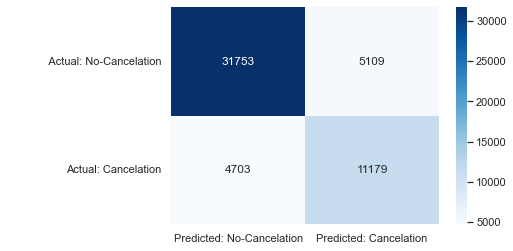

In [122]:
X = pd.get_dummies(data.drop(columns=not_selected))
y = data['IsCanceled']

#Make predictions
Prediction = catboost.predict(X)
expected_y= data['IsCanceled']

print('__')
print('                                                TEST                                                 ')
print('-----------------------------------------------------------------------------------------------------------')
print(classification_report(expected_y, Prediction))

cm=confusion_matrix(expected_y, Prediction)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted: No-Cancelation', 'Predicted: Cancelation'], 
                                 index=['              Actual: No-Cancelation', 'Actual: Cancelation'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')

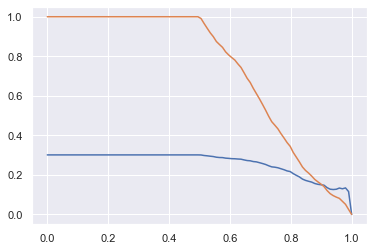

In [123]:
predictions = catboost.predict_proba(X_test)
thresholds = np.linspace(0, 1, 100)
precision_scores = []
recall_scores = []
for threshold in thresholds:
    adjusted_predictions = [1 if (p > threshold).any() else 0 for p in predictions]
    precision_scores.append(precision_score(expected_y_test, adjusted_predictions))
    recall_scores.append(recall_score(expected_y_test, adjusted_predictions))
plt.plot(thresholds, precision_scores, label="precision")
plt.plot(thresholds, recall_scores, label="recall")
plt.show()